<a href="https://colab.research.google.com/github/settilea/Proyecto_final_Data_Science_1/blob/main/Leandro_Setti_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de retrasos en vuelos desde los aeropuertos de Nueva York

En este proyecto busco abordar un problema recurrente en la aviación comercial: la predicción de retrasos en los vuelos. Los retrasos no solo afectan la puntualidad y satisfacción de los pasajeros, sino que también tienen un impacto operativo y económico significativo para las aerolíneas y aeropuertos. Mi objetivo es desarrollar un modelo que permita anticipar la probabilidad de que un vuelo salga demorado, considerando tanto factores operativos como condiciones meteorológicas, con el fin de aportar una herramienta de análisis y toma de decisiones basada en datos.

Para este trabajo, utilicé un subconjunto del dataset público Flight Delay Prediction obtenido de la plataforma Kaggel, centrado exclusivamente en los vuelos que despegaron desde los aeropuertos JFK (John F. Kennedy) y LGA (LaGuardia), ambos ubicados en la ciudad de Nueva York. Elegí acotar el análisis a estos dos aeropuertos debido a su alto volumen de operaciones y a las variaciones climáticas significativas que enfrentan a lo largo del año. El dataset contiene información detallada sobre los vuelos, como la aerolínea operadora, la fecha y hora de salida programada, los retrasos en la salida, y otros datos complementarios.

Además, integré al análisis un segundo dataset proveniente de la API de Meteostat, que proporciona variables meteorológicas históricas (como temperatura, velocidad y dirección del viento, visibilidad, presión atmosférica y precipitaciones) registradas en los mismos aeropuertos y sincronizadas por fecha y hora. Esta integración me permite evaluar de forma conjunta cómo las condiciones del clima influyen en los retrasos de los vuelos.

En este contexto, se plantean las siguientes hipótesis de trabajo:

- H₀: Los retrasos en los vuelos tienen un origen aleatorio y no están correlacionados con las variables operativas y/o meteorológicas.

- H₁: Los retrasos en los vuelos pueden predecirse mediante la correlación de variables operativas y meteorológicas.

El enfoque metodológico comienza con un análisis exploratorio de datos (EDA) para identificar patrones, correlaciones y relaciones potenciales entre las variables. A partir de ello, se busca construir un modelo predictivo que estime la probabilidad de retraso mayor o igual a 15 minutos, umbral estándar en la industria para definir un vuelo como “retrasado”. En última instancia, este proyecto pretende aportar evidencia empírica sobre los factores que más inciden en la puntualidad de los vuelos, contribuyendo al desarrollo de estrategias más eficientes de gestión aeroportuaria.

## importación de librerías y dependencias

In [ ]:
pip install meteostat

In [ ]:
import os
import kagglehub
from getpass import getpass
from google.colab import userdata
import pandas as pd
import os
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from meteostat import Hourly
import numpy as np

## Extracción del dataset de Kaggle
Se extraen todos los archivos en formato.csv dentro de un diccionario que luego se transforman en dataframes de pandas

In [ ]:
# Configuración de variables de entorno
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

# Descargar y descomprimir
!curl -L -o flight-delays.zip https://www.kaggle.com/api/v1/datasets/download/usdot/flight-delays
!unzip -q flight-delays.zip

# Ver TODOS los archivos que se extrajeron
print("=== Archivos extraídos ===")
!ls -la

# Ver específicamente los archivos CSV
print("\n=== Archivos CSV encontrados ===")
csv_files = [f for f in os.listdir('.') if f.endswith('.csv')]
for file in csv_files:
    size = os.path.getsize(file) / (1024*1024)  # Tamaño en MB
    print(f"📄 {file} ({size:.1f} MB)")

# Cargar cada archivo CSV
dataframes = {}
for csv_file in csv_files:
    try:
        print(f"\nCargando {csv_file}...")
        df_name = csv_file.replace('.csv', '')
        dataframes[df_name] = pd.read_csv(csv_file)
        print(f"✅ {csv_file}: {dataframes[df_name].shape} (filas, columnas)")
        print(f"Columnas: {list(dataframes[df_name].columns)}")
    except Exception as e:
        print(f"❌ Error cargando {csv_file}: {e}")

# Mostrar información de cada dataset
for name, df in dataframes.items():
    print(f"\n=== {name.upper()} ===")
    print(f"Shape: {df.shape}")
    print("Primeras 3 filas:")
    print(df.head(3))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  190M  100  190M    0     0  97.4M      0  0:00:01  0:00:01 --:--:--  161M
=== Archivos extraídos ===
total 773952
drwxr-xr-x 1 root root      4096 Oct 16 13:55 .
drwxr-xr-x 1 root root      4096 Oct 16 13:53 ..
-rw-r--r-- 1 root root       359 Sep 20  2019 airlines.csv
-rw-r--r-- 1 root root     23867 Sep 20  2019 airports.csv
drwxr-xr-x 4 root root      4096 Oct 14 13:41 .config
-rw-r--r-- 1 root root 200067268 Oct 16 13:55 flight-delays.zip
-rw-r--r-- 1 root root 592406591 Sep 20  2019 flights.csv
drwxr-xr-x 1 root root      4096 Oct 14 13:41 sample_data

=== Archivos CSV encontrados ===
📄 flights.csv (565.0 MB)
📄 airlines.csv (0.0 MB)
📄 airports.csv (0.0 MB)

Cargando flights.csv...


✅ flights.csv: (5819079, 31) (filas, columnas)
Columnas: ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']

Cargando airlines.csv...
✅ airlines.csv: (14, 2) (filas, columnas)
Columnas: ['IATA_CODE', 'AIRLINE']

Cargando airports.csv...
✅ airports.csv: (322, 7) (filas, columnas)
Columnas: ['IATA_CODE', 'AIRPORT', 'CITY', 'STATE', 'COUNTRY', 'LATITUDE', 'LONGITUDE']

=== FLIGHTS ===
Shape: (5819079, 31)
Primeras 3 filas:
   YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4      AS             98      N407AS

In [ ]:
flights_df = dataframes['flights']      # Acceder al dataframe de vuelos
airports_df = dataframes['airports']    # Acceder al dataframe de aeropuertos
airlines_df = dataframes['airlines']    # Acceder al dataframe de aerolíneas

In [ ]:
flights_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


datos del dataframe flights_df
- 'YEAR' Año de Scheduled Departure
- 'MONTH' Mes de Scheduled Departure
- 'DAY' día de Scheduled Departure
- 'DAY_OF_WEEK' día de la semana del Scheduled Departure
- 'AIRLINE' Aerolinea (Código)
- 'FLIGHT_NUMBER' Numero de Vuelo
- 'TAIL_NUMBER' Numero de matricula del avión
- 'ORIGIN_AIRPORT' Aeropuerto de Origen
- 'DESTINATION_AIRPORT' Aeropuerto de destino
- 'SCHEDULED_DEPARTURE' hora de salida(hora y minuto como int)
- 'DEPARTURE_TIME' hora de despacho de la aeronave
- 'DEPARTURE_DELAY' diferencia entre SCHEDULED_DEPARTURE y DEPARTURE_TIME
- 'TAXI_OUT' Minutos de rodaje desde la puerta hasta la pista de despegue
- 'WHEELS_OFF' Hora (en formato hhmm) en que las ruedas despegan
- 'SCHEDULED_TIME' Tiempo programado total de vuelo (en minutos)
- 'ELAPSED_TIME' Tiempo real total del vuelo (en minutos)
- 'AIR_TIME' Tiempo efectivo en el aire (en minutos)
- 'DISTANCE' Distancia entre aeropuertos (en millas)
- 'WHEELS_ON' Hora (en formato hhmm) en que las ruedas tocan pista al aterrizar.
- 'TAXI_IN' Tiempo de rodaje desde la pista hasta la puerta de llegada.
- 'SCHEDULED_ARRIVAL' Hora programada de llegada.
- 'ARRIVAL_TIME' Hora real de llegada.
- 'ARRIVAL_DELAY' Diferencia (en minutos) entre la hora real y la programada de llegada.
- 'DIVERTED' Indica si el vuelo fue desviado (1) o no (0).
- 'CANCELLED' Indica si el vuelo fue cancelado (1) o no (0).
- 'CANCELLATION_REASON' Motivo de cancelación (por ejemplo, A=aerolínea, B=clima, C=NAS, D=seguridad).
- 'AIR_SYSTEM_DELAY' Retraso atribuible al sistema aéreo (control de tráfico, etc.).
- 'SECURITY_DELAY' Retraso atribuible a controles o incidentes de seguridad.
- 'AIRLINE_DELAY' Retraso atribuible a la aerolínea (tripulación, mantenimiento, etc.).
- 'LATE_AIRCRAFT_DELAY' Retraso causado por la llegada tardía del avión desde otro vuelo previo.
- 'WEATHER_DELAY' Retraso causado por condiciones meteorológicas.



Identificamos los vuelos retrasados (aquellos que demoraron más de 15 minutos entre el Scheduled departure y el Departure Time)

In [ ]:
flights_df["DELAYED"] = flights_df["DEPARTURE_DELAY"] >= 15

#contamos la cantidad de vuelos retrasados
flights_df["DELAYED"].value_counts()

,count
DELAYED,
False,4761525
True,1057554


### Filtramos solamente los vuelos que tienen origen en la ciudad de Nueva York

In [ ]:
# primero filtramos en el DF de aeropuertos los aeropuertos de la ciudad de Nueva York
airports_df = airports_df[airports_df['CITY'] == 'New York']
airports_df.head(10)

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
166,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893
182,LGA,LaGuardia Airport (Marine Air Terminal),New York,NY,USA,40.77724,-73.87261


In [ ]:
# ahora realizamos la union entre el DF de aeropuertos y de vuelos con la FK en el IATA_CODE y ORIGIN_AIRPORT
flights_df = pd.merge(flights_df, airports_df, left_on='ORIGIN_AIRPORT', right_on='IATA_CODE', how='left')
flights_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DELAYED,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# ahora filtramos por la ciudad del aeropuerto = New York
flights_df = flights_df[flights_df['CITY'] == 'New York']
flights_df.head(10)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DELAYED,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
97,2015,1,1,4,B6,2023,N324JB,JFK,SJU,535,...,0.0,0.0,True,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893
120,2015,1,1,4,AA,2299,N3LLAA,JFK,MIA,545,...,0.0,0.0,True,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893
123,2015,1,1,4,B6,939,N794JB,JFK,BQN,545,...,NaN,NaN,False,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893
210,2015,1,1,4,AA,1103,N3HCAA,LGA,DFW,600,...,NaN,NaN,False,LGA,LaGuardia Airport (Marine Air Terminal),New York,NY,USA,40.77724,-73.87261
216,2015,1,1,4,AA,1297,N3JYAA,LGA,MIA,600,...,0.0,0.0,True,LGA,LaGuardia Airport (Marine Air Terminal),New York,NY,USA,40.77724,-73.87261
238,2015,1,1,4,B6,353,N570JB,JFK,PBI,600,...,NaN,NaN,False,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893
242,2015,1,1,4,B6,371,N708JB,LGA,FLL,600,...,NaN,NaN,False,LGA,LaGuardia Airport (Marine Air Terminal),New York,NY,USA,40.77724,-73.87261
243,2015,1,1,4,B6,583,N531JB,JFK,MCO,600,...,NaN,NaN,False,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893
245,2015,1,1,4,B6,525,N645JB,JFK,TPA,600,...,NaN,NaN,False,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893
253,2015,1,1,4,DL,421,N967DL,JFK,ATL,600,...,NaN,NaN,False,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893


### Agregamos los datos meteorológicos

In [ ]:
# Seteamos el rango de fechas
start = datetime(2015, 1, 1)
end = datetime(2015, 12, 31, 23, 59)

# obtenemos los registros horarios
data_lga = Hourly('72503', start, end)
data_lga = data_lga.fetch()
data_jfk = Hourly('74486', start, end)
data_jfk = data_jfk.fetch()

# Print DataFrame
print(data_lga)
print(data_jfk)

                     temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt    pres  \
time                                                                           
2015-01-01 00:00:00  -1.1 -13.9  37.0  <NA>  <NA>  270.0  20.5  <NA>  1024.2   
2015-01-01 01:00:00  -1.1 -13.9  37.0   0.0  <NA>  250.0  16.6  <NA>  1023.8   
2015-01-01 02:00:00  -1.1 -14.3  36.0   0.0  <NA>  240.0  22.3  <NA>  1023.3   
2015-01-01 03:00:00  -1.7 -12.9  42.0   0.0  <NA>  230.0  18.4  <NA>  1022.6   
2015-01-01 04:00:00  -1.7 -12.1  45.0   0.0  <NA>  230.0  18.4  <NA>  1022.2   
...                   ...   ...   ...   ...   ...    ...   ...   ...     ...   
2015-12-31 19:00:00   8.9   1.8  61.0   0.0  <NA>  320.0  18.4  <NA>  1017.0   
2015-12-31 20:00:00   8.9   1.8  61.0   0.0  <NA>  320.0  24.1  <NA>  1016.7   
2015-12-31 21:00:00   8.9   1.8  61.0   0.0  <NA>  310.0  24.1  <NA>  1017.8   
2015-12-31 22:00:00   8.3   0.5  58.0   0.0  <NA>  310.0  16.6  <NA>  1018.1   
2015-12-31 23:00:00   8.3   1.0  60.0   

Column	Description	Type
station	The Meteostat ID of the weather station (only if query refers to multiple stations)	String
- time	The datetime of the observation	Datetime64
- temp	The air temperature in °C	Float64
- dwpt	The dew point in °C	Float64 (punto de rocío)
- rhum	The relative humidity in percent (%)	Float64
- prcp	The one hour precipitation total in mm	Float64
- snow	The snow depth in mm	Float64
- wdir	The average wind direction in degrees (°)	Float64
- wspd	The average wind speed in km/h	Float64
- wpgt	The peak wind gust in km/h	Float64
- pres	The average sea-level air pressure in hPa	Float64
- tsun	The one hour sunshine total in minutes (m)	Float64
- coco	The weather condition code	Float64

In [ ]:
#Agregamos el código IATA para luego poder realizar merge con el DataFrame principal

#primero pasamos la información a DataFrame
df_data_lga = pd.DataFrame(data_lga)
df_data_jfk = pd.DataFrame(data_jfk)

# Agregar columna con nombre de estacíon meteorológica
df_data_lga['Estación'] = "LGA"
df_data_jfk['Estación'] = "JFK"

#unimos los dos dataframes en uno solo
df_meteo = pd.concat([df_data_lga,df_data_jfk], ignore_index=False)
df_meteo.sort_values(by='time')

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,Estación
time,,,,,,,,,,,,
2015-01-01 00:00:00,-1.1,-13.9,37.0,<NA>,<NA>,270.0,20.5,<NA>,1024.2,<NA>,<NA>,LGA
2015-01-01 00:00:00,-0.6,-13.8,36.0,<NA>,<NA>,250.0,20.5,<NA>,1024.8,<NA>,<NA>,JFK
2015-01-01 01:00:00,-0.6,-13.8,36.0,0.0,<NA>,250.0,24.1,<NA>,1024.5,<NA>,<NA>,JFK
2015-01-01 01:00:00,-1.1,-13.9,37.0,0.0,<NA>,250.0,16.6,<NA>,1023.8,<NA>,<NA>,LGA
2015-01-01 02:00:00,-0.6,-13.1,38.0,0.0,<NA>,250.0,20.5,<NA>,1024.0,<NA>,<NA>,JFK
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31 21:00:00,9.4,1.8,59.0,0.0,<NA>,310.0,20.5,<NA>,1018.1,<NA>,<NA>,JFK
2015-12-31 22:00:00,8.9,0.6,56.0,0.0,<NA>,310.0,25.9,<NA>,1018.4,<NA>,<NA>,JFK
2015-12-31 22:00:00,8.3,0.5,58.0,0.0,<NA>,310.0,16.6,<NA>,1018.1,<NA>,<NA>,LGA


In [ ]:
df_meteo.describe()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
count,17519.0,17518.0,17518.0,16344.0,0.0,17321.0,17518.0,0.0,17400.0,0.0,116.0
mean,13.408362,5.297785,60.588138,0.109123,<NA>,189.195197,16.949931,<NA>,1017.976029,<NA>,6.112069
std,10.462204,11.035639,18.309087,0.759622,<NA>,110.431178,9.258942,<NA>,7.738013,<NA>,1.381691
min,-16.1,-26.7,10.0,0.0,<NA>,0.0,0.0,<NA>,991.3,<NA>,5.0
25%,5.6,-2.7,46.0,0.0,<NA>,80.0,11.2,<NA>,1012.8,<NA>,5.0
50%,13.9,7.6,60.0,0.0,<NA>,200.0,16.6,<NA>,1017.7,<NA>,5.0
75%,22.2,14.4,75.0,0.0,<NA>,290.0,22.3,<NA>,1023.0,<NA>,7.0
max,35.0,24.0,100.0,42.4,<NA>,360.0,59.4,<NA>,1044.1,<NA>,14.0


In [ ]:
df_meteo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17519 entries, 2015-01-01 00:00:00 to 2015-12-31 23:00:00
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   temp      17519 non-null  Float64
 1   dwpt      17518 non-null  Float64
 2   rhum      17518 non-null  Float64
 3   prcp      16344 non-null  Float64
 4   snow      0 non-null      Float64
 5   wdir      17321 non-null  Float64
 6   wspd      17518 non-null  Float64
 7   wpgt      0 non-null      Float64
 8   pres      17400 non-null  Float64
 9   tsun      0 non-null      Float64
 10  coco      116 non-null    Float64
 11  Estación  17519 non-null  object 
dtypes: Float64(11), object(1)
memory usage: 1.9+ MB


Transformamos el df_meteo para poder hacer el merge con el flights_df

In [ ]:
df_meteo.reset_index(inplace=True)
df_meteo.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,Estación
0,2015-01-01 00:00:00,-1.1,-13.9,37.0,<NA>,<NA>,270.0,20.5,<NA>,1024.2,<NA>,<NA>,LGA
1,2015-01-01 01:00:00,-1.1,-13.9,37.0,0.0,<NA>,250.0,16.6,<NA>,1023.8,<NA>,<NA>,LGA
2,2015-01-01 02:00:00,-1.1,-14.3,36.0,0.0,<NA>,240.0,22.3,<NA>,1023.3,<NA>,<NA>,LGA
3,2015-01-01 03:00:00,-1.7,-12.9,42.0,0.0,<NA>,230.0,18.4,<NA>,1022.6,<NA>,<NA>,LGA
4,2015-01-01 04:00:00,-1.7,-12.1,45.0,0.0,<NA>,230.0,18.4,<NA>,1022.2,<NA>,<NA>,LGA


In [ ]:
df_meteo.sort_values(by='time')

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,Estación
0,2015-01-01 00:00:00,-1.1,-13.9,37.0,<NA>,<NA>,270.0,20.5,<NA>,1024.2,<NA>,<NA>,LGA
8759,2015-01-01 00:00:00,-0.6,-13.8,36.0,<NA>,<NA>,250.0,20.5,<NA>,1024.8,<NA>,<NA>,JFK
8760,2015-01-01 01:00:00,-0.6,-13.8,36.0,0.0,<NA>,250.0,24.1,<NA>,1024.5,<NA>,<NA>,JFK
1,2015-01-01 01:00:00,-1.1,-13.9,37.0,0.0,<NA>,250.0,16.6,<NA>,1023.8,<NA>,<NA>,LGA
8761,2015-01-01 02:00:00,-0.6,-13.1,38.0,0.0,<NA>,250.0,20.5,<NA>,1024.0,<NA>,<NA>,JFK
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17516,2015-12-31 21:00:00,9.4,1.8,59.0,0.0,<NA>,310.0,20.5,<NA>,1018.1,<NA>,<NA>,JFK
17517,2015-12-31 22:00:00,8.9,0.6,56.0,0.0,<NA>,310.0,25.9,<NA>,1018.4,<NA>,<NA>,JFK
8757,2015-12-31 22:00:00,8.3,0.5,58.0,0.0,<NA>,310.0,16.6,<NA>,1018.1,<NA>,<NA>,LGA
8758,2015-12-31 23:00:00,8.3,1.0,60.0,0.0,<NA>,310.0,14.8,<NA>,1018.4,<NA>,<NA>,LGA


In [ ]:
df_meteo['time'] = pd.to_datetime(df_meteo['time'])
df_meteo['YEAR'] = df_meteo['time'].dt.year
df_meteo['MONTH'] = df_meteo['time'].dt.month
df_meteo['DAY'] = df_meteo['time'].dt.day
df_meteo['HOUR'] = df_meteo['time'].dt.hour

df_meteo.sort_values(by='time')

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,Estación,YEAR,MONTH,DAY,HOUR
0,2015-01-01 00:00:00,-1.1,-13.9,37.0,<NA>,<NA>,270.0,20.5,<NA>,1024.2,<NA>,<NA>,LGA,2015,1,1,0
8759,2015-01-01 00:00:00,-0.6,-13.8,36.0,<NA>,<NA>,250.0,20.5,<NA>,1024.8,<NA>,<NA>,JFK,2015,1,1,0
8760,2015-01-01 01:00:00,-0.6,-13.8,36.0,0.0,<NA>,250.0,24.1,<NA>,1024.5,<NA>,<NA>,JFK,2015,1,1,1
1,2015-01-01 01:00:00,-1.1,-13.9,37.0,0.0,<NA>,250.0,16.6,<NA>,1023.8,<NA>,<NA>,LGA,2015,1,1,1
8761,2015-01-01 02:00:00,-0.6,-13.1,38.0,0.0,<NA>,250.0,20.5,<NA>,1024.0,<NA>,<NA>,JFK,2015,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17516,2015-12-31 21:00:00,9.4,1.8,59.0,0.0,<NA>,310.0,20.5,<NA>,1018.1,<NA>,<NA>,JFK,2015,12,31,21
17517,2015-12-31 22:00:00,8.9,0.6,56.0,0.0,<NA>,310.0,25.9,<NA>,1018.4,<NA>,<NA>,JFK,2015,12,31,22
8757,2015-12-31 22:00:00,8.3,0.5,58.0,0.0,<NA>,310.0,16.6,<NA>,1018.1,<NA>,<NA>,LGA,2015,12,31,22
8758,2015-12-31 23:00:00,8.3,1.0,60.0,0.0,<NA>,310.0,14.8,<NA>,1018.4,<NA>,<NA>,LGA,2015,12,31,23


Pasamos algunas de las variables a caegoricas para poder agriparlas

In [ ]:
# pasamos la variable wdir (dirección del viento) a 8 puntos cardinales para que su análisis sea más sencillo

def direccion_cardinal(wdir):
    if (wdir >= 337.5) or (wdir < 22.5):
        return 'N'
    elif 22.5 <= wdir < 67.5:
        return 'NE'
    elif 67.5 <= wdir < 112.5:
        return 'E'
    elif 112.5 <= wdir < 157.5:
        return 'SE'
    elif 157.5 <= wdir < 202.5:
        return 'S'
    elif 202.5 <= wdir < 247.5:
        return 'SW'
    elif 247.5 <= wdir < 292.5:
        return 'W'
    elif 292.5 <= wdir < 337.5:
        return 'NW'
    else:
        return np.nan

# Crear una nueva columna con la categoría de dirección
df_meteo['wind_direction'] = df_meteo['wdir'].apply(direccion_cardinal)


In [ ]:
df_meteo.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,Estación,YEAR,MONTH,DAY,HOUR,wind_direction
0,2015-01-01 00:00:00,-1.1,-13.9,37.0,<NA>,<NA>,270.0,20.5,<NA>,1024.2,<NA>,<NA>,LGA,2015,1,1,0,W
1,2015-01-01 01:00:00,-1.1,-13.9,37.0,0.0,<NA>,250.0,16.6,<NA>,1023.8,<NA>,<NA>,LGA,2015,1,1,1,W
2,2015-01-01 02:00:00,-1.1,-14.3,36.0,0.0,<NA>,240.0,22.3,<NA>,1023.3,<NA>,<NA>,LGA,2015,1,1,2,SW
3,2015-01-01 03:00:00,-1.7,-12.9,42.0,0.0,<NA>,230.0,18.4,<NA>,1022.6,<NA>,<NA>,LGA,2015,1,1,3,SW
4,2015-01-01 04:00:00,-1.7,-12.1,45.0,0.0,<NA>,230.0,18.4,<NA>,1022.2,<NA>,<NA>,LGA,2015,1,1,4,SW


In [ ]:
# pasamos la variable wspd (veolcidad del viento) a variable categótica utilizando la escala de Beaufort

def clasificar_velocidad(v):
    if pd.isna(v):
        return np.nan
    elif v <= 1:
        return 'Calma'
    elif v <= 6:
        return 'Brisa ligera'
    elif v <= 12:
        return 'Brisa suave'
    elif v <= 19:
        return 'Brisa moderada'
    elif v <= 29:
        return 'Brisa fresca'
    elif v <= 39:
        return 'Brisa fuerte'
    elif v <= 50:
        return 'Viento fuerte'
    elif v <= 62:
        return 'Viento muy fuerte'
    elif v <= 75:
        return 'Temporal'
    elif v <= 87:
        return 'Temporal fuerte'
    elif v <= 102:
        return 'Tormenta'
    elif v <= 117:
        return 'Tormenta violenta'
    else:
        return 'Huracán'

# Aplicar clasificación al DataFrame
df_meteo["wind_category"] = df_meteo["wspd"].apply(clasificar_velocidad)

df_meteo.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,Estación,YEAR,MONTH,DAY,HOUR,wind_direction,wind_category
0,2015-01-01 00:00:00,-1.1,-13.9,37.0,<NA>,<NA>,270.0,20.5,<NA>,1024.2,<NA>,<NA>,LGA,2015,1,1,0,W,Brisa fresca
1,2015-01-01 01:00:00,-1.1,-13.9,37.0,0.0,<NA>,250.0,16.6,<NA>,1023.8,<NA>,<NA>,LGA,2015,1,1,1,W,Brisa moderada
2,2015-01-01 02:00:00,-1.1,-14.3,36.0,0.0,<NA>,240.0,22.3,<NA>,1023.3,<NA>,<NA>,LGA,2015,1,1,2,SW,Brisa fresca
3,2015-01-01 03:00:00,-1.7,-12.9,42.0,0.0,<NA>,230.0,18.4,<NA>,1022.6,<NA>,<NA>,LGA,2015,1,1,3,SW,Brisa moderada
4,2015-01-01 04:00:00,-1.7,-12.1,45.0,0.0,<NA>,230.0,18.4,<NA>,1022.2,<NA>,<NA>,LGA,2015,1,1,4,SW,Brisa moderada


In [ ]:
#reemplazamos los valores null por 0 en las columnas 'prcp' y 'snow'

df_meteo[["prcp", "snow"]] = df_meteo[["prcp", "snow"]].fillna(0)

In [ ]:
# ahora pasamos las variables prcp y snow a una variable categórica para indicar si hubo precipitación de lluvia o nieve, en caso de que hubiera de las dos dentro de la medición, se tomará la de mayor valor. Si no hubo precipitaciones se pondrá "none"

def clasificar_precipitacion(row):
    prcp = row.get("prcp", 0)
    snow = row.get("snow", 0)

    if (pd.isna(prcp) or prcp == 0) and (pd.isna(snow) or snow == 0):
        return "None"
    elif prcp >= snow:
        return "Rain"
    else:
        return "Snow"

df_meteo["precipitation_type"] = df_meteo.apply(clasificar_precipitacion, axis=1)


In [ ]:
# por último clasificamos la cantidad de precipitación en distintos niveles

def clasificar_intensidad_precipitacion(row):
    prcp = row.get("prcp", 0) or 0
    snow = row.get("snow", 0) or 0

    total = prcp + snow

    if total == 0:
        return "Sin precipitación"
    elif total <= 2.5:
        return "Ligera"
    elif total <= 7.5:
        return "Moderada"
    elif total <= 50:
        return "Fuerte"
    else:
        return "Extrema"

df_meteo["precipitation_intensity"] = df_meteo.apply(clasificar_intensidad_precipitacion, axis=1)

df_meteo.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,...,coco,Estación,YEAR,MONTH,DAY,HOUR,wind_direction,wind_category,precipitation_type,precipitation_intensity
0,2015-01-01 00:00:00,-1.1,-13.9,37.0,0.0,0.0,270.0,20.5,<NA>,1024.2,...,<NA>,LGA,2015,1,1,0,W,Brisa fresca,None,Sin precipitación
1,2015-01-01 01:00:00,-1.1,-13.9,37.0,0.0,0.0,250.0,16.6,<NA>,1023.8,...,<NA>,LGA,2015,1,1,1,W,Brisa moderada,None,Sin precipitación
2,2015-01-01 02:00:00,-1.1,-14.3,36.0,0.0,0.0,240.0,22.3,<NA>,1023.3,...,<NA>,LGA,2015,1,1,2,SW,Brisa fresca,None,Sin precipitación
3,2015-01-01 03:00:00,-1.7,-12.9,42.0,0.0,0.0,230.0,18.4,<NA>,1022.6,...,<NA>,LGA,2015,1,1,3,SW,Brisa moderada,None,Sin precipitación
4,2015-01-01 04:00:00,-1.7,-12.1,45.0,0.0,0.0,230.0,18.4,<NA>,1022.2,...,<NA>,LGA,2015,1,1,4,SW,Brisa moderada,None,Sin precipitación


La variable 'coco' indica la condición climática con la siguiente lista
|Code	Weather | Condition |
|-------------|-----------|
|1	|Clear|
|2	|Fair|
|3	|Cloudy|
|4	|Overcast|
|5	|Fog|
|6	|Freezing Fog|
|7	|Light Rain|
|8	|Rain|
|9	|Heavy Rain|
|10	|Freezing Rain|
|11	|Heavy Freezing Rain|
|12	|Sleet|
|13	|Heavy Sleet|
|14	|Light Snowfall|
|15	|Snowfall|
|16	|Heavy Snowfall|
|17	|Rain Shower|
|18	|Heavy Rain Shower|
|19	|Sleet Shower|
|20	|Heavy Sleet Shower|
|21	|Snow Shower|
|22	|Heavy Snow Shower|
|23	|Lightning|
|24	|Hail|
|25	|Thunderstorm|
|26	|Heavy Thunderstorm|
|27	|Storm

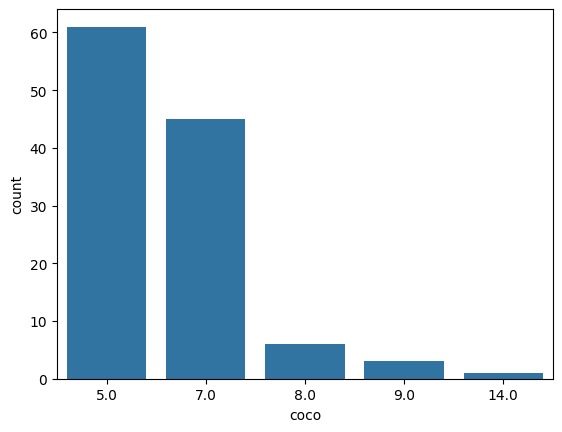

In [ ]:
# mostramos las frecuencias de la variable 'coco' con un gráfico de distribución
sns.countplot(data=df_meteo, x='coco')
plt.show()


cómo las variables de presipitación ya las tenemos registradas, solo tomaremos la variable 5 (Fog - Niebla) para agregarla a nuestro dataframe, ya que es importante para la operación aeronáutica

In [ ]:
# Agregamos una columna nueva 'fog' que indique si la columna 'coco' tiene valor 5
df_meteo['fog'] = df_meteo['coco'] == 5

df_meteo.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,...,Estación,YEAR,MONTH,DAY,HOUR,wind_direction,wind_category,precipitation_type,precipitation_intensity,fog
0,2015-01-01 00:00:00,-1.1,-13.9,37.0,0.0,0.0,270.0,20.5,<NA>,1024.2,...,LGA,2015,1,1,0,W,Brisa fresca,None,Sin precipitación,<NA>
1,2015-01-01 01:00:00,-1.1,-13.9,37.0,0.0,0.0,250.0,16.6,<NA>,1023.8,...,LGA,2015,1,1,1,W,Brisa moderada,None,Sin precipitación,<NA>
2,2015-01-01 02:00:00,-1.1,-14.3,36.0,0.0,0.0,240.0,22.3,<NA>,1023.3,...,LGA,2015,1,1,2,SW,Brisa fresca,None,Sin precipitación,<NA>
3,2015-01-01 03:00:00,-1.7,-12.9,42.0,0.0,0.0,230.0,18.4,<NA>,1022.6,...,LGA,2015,1,1,3,SW,Brisa moderada,None,Sin precipitación,<NA>
4,2015-01-01 04:00:00,-1.7,-12.1,45.0,0.0,0.0,230.0,18.4,<NA>,1022.2,...,LGA,2015,1,1,4,SW,Brisa moderada,None,Sin precipitación,<NA>


In [ ]:
df_meteo['fog'] = df_meteo['fog'].fillna(False)

df_meteo.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,...,Estación,YEAR,MONTH,DAY,HOUR,wind_direction,wind_category,precipitation_type,precipitation_intensity,fog
0,2015-01-01 00:00:00,-1.1,-13.9,37.0,0.0,0.0,270.0,20.5,<NA>,1024.2,...,LGA,2015,1,1,0,W,Brisa fresca,None,Sin precipitación,False
1,2015-01-01 01:00:00,-1.1,-13.9,37.0,0.0,0.0,250.0,16.6,<NA>,1023.8,...,LGA,2015,1,1,1,W,Brisa moderada,None,Sin precipitación,False
2,2015-01-01 02:00:00,-1.1,-14.3,36.0,0.0,0.0,240.0,22.3,<NA>,1023.3,...,LGA,2015,1,1,2,SW,Brisa fresca,None,Sin precipitación,False
3,2015-01-01 03:00:00,-1.7,-12.9,42.0,0.0,0.0,230.0,18.4,<NA>,1022.6,...,LGA,2015,1,1,3,SW,Brisa moderada,None,Sin precipitación,False
4,2015-01-01 04:00:00,-1.7,-12.1,45.0,0.0,0.0,230.0,18.4,<NA>,1022.2,...,LGA,2015,1,1,4,SW,Brisa moderada,None,Sin precipitación,False


Ahora armamos un nuevo df unicamente con las variables que quiero usar en mi DataFrame principal

In [ ]:
df_meteo_final = df_meteo[['YEAR', 'MONTH', 'DAY', 'HOUR', 'temp', 'dwpt', 'rhum', 'Estación', 'wind_direction', 'wind_category', 'precipitation_type', 'precipitation_intensity', 'fog']]
df_meteo_final = df_meteo_final.rename(columns={'Estación': 'estacion'})
df_meteo_final.head()

,YEAR,MONTH,DAY,HOUR,temp,dwpt,rhum,estacion,wind_direction,wind_category,precipitation_type,precipitation_intensity,fog
0,2015,1,1,0,-1.1,-13.9,37.0,LGA,W,Brisa fresca,None,Sin precipitación,False
1,2015,1,1,1,-1.1,-13.9,37.0,LGA,W,Brisa moderada,None,Sin precipitación,False
2,2015,1,1,2,-1.1,-14.3,36.0,LGA,SW,Brisa fresca,None,Sin precipitación,False
3,2015,1,1,3,-1.7,-12.9,42.0,LGA,SW,Brisa moderada,None,Sin precipitación,False
4,2015,1,1,4,-1.7,-12.1,45.0,LGA,SW,Brisa moderada,None,Sin precipitación,False


Ahora pasamos a acondicionar el DataFrame principal de flights para hacer el merge con los datos meteorológicos

In [ ]:
flights_df.head(10)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DELAYED,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
97,2015,1,1,4,B6,2023,N324JB,JFK,SJU,535,...,0.0,0.0,True,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893
120,2015,1,1,4,AA,2299,N3LLAA,JFK,MIA,545,...,0.0,0.0,True,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893
123,2015,1,1,4,B6,939,N794JB,JFK,BQN,545,...,NaN,NaN,False,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893
210,2015,1,1,4,AA,1103,N3HCAA,LGA,DFW,600,...,NaN,NaN,False,LGA,LaGuardia Airport (Marine Air Terminal),New York,NY,USA,40.77724,-73.87261
216,2015,1,1,4,AA,1297,N3JYAA,LGA,MIA,600,...,0.0,0.0,True,LGA,LaGuardia Airport (Marine Air Terminal),New York,NY,USA,40.77724,-73.87261
238,2015,1,1,4,B6,353,N570JB,JFK,PBI,600,...,NaN,NaN,False,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893
242,2015,1,1,4,B6,371,N708JB,LGA,FLL,600,...,NaN,NaN,False,LGA,LaGuardia Airport (Marine Air Terminal),New York,NY,USA,40.77724,-73.87261
243,2015,1,1,4,B6,583,N531JB,JFK,MCO,600,...,NaN,NaN,False,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893
245,2015,1,1,4,B6,525,N645JB,JFK,TPA,600,...,NaN,NaN,False,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893
253,2015,1,1,4,DL,421,N967DL,JFK,ATL,600,...,NaN,NaN,False,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893


In [ ]:
# agregamos el campo 'HOUR' dividindo el campo 'SCHEDULED_DEPARTURE' por 100 y sin resto.
flights_df['HOUR'] = flights_df['SCHEDULED_DEPARTURE'] // 100
flights_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,WEATHER_DELAY,DELAYED,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,HOUR
97,2015,1,1,4,B6,2023,N324JB,JFK,SJU,535,...,0.0,True,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893,5
120,2015,1,1,4,AA,2299,N3LLAA,JFK,MIA,545,...,0.0,True,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893,5
123,2015,1,1,4,B6,939,N794JB,JFK,BQN,545,...,NaN,False,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893,5
210,2015,1,1,4,AA,1103,N3HCAA,LGA,DFW,600,...,NaN,False,LGA,LaGuardia Airport (Marine Air Terminal),New York,NY,USA,40.77724,-73.87261,6
216,2015,1,1,4,AA,1297,N3JYAA,LGA,MIA,600,...,0.0,True,LGA,LaGuardia Airport (Marine Air Terminal),New York,NY,USA,40.77724,-73.87261,6


Creo un nuevo DataFrame de Flights solo con los datos que entiendo relevantes para el análisis.

In [ ]:
df_flights_final = flights_df[['YEAR', 'MONTH', 'DAY', 'HOUR', 'DAY_OF_WEEK', 'ORIGIN_AIRPORT', 'AIRLINE', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'DELAYED']]
df_flights_final.head()

,YEAR,MONTH,DAY,HOUR,DAY_OF_WEEK,ORIGIN_AIRPORT,AIRLINE,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DELAYED
97,2015,1,1,5,4,JFK,B6,0.0,0.0,19.0,0.0,0.0,True
120,2015,1,1,5,4,JFK,AA,14.0,0.0,55.0,0.0,0.0,True
123,2015,1,1,5,4,JFK,B6,NaN,NaN,NaN,NaN,NaN,False
210,2015,1,1,6,4,LGA,AA,NaN,NaN,NaN,NaN,NaN,False
216,2015,1,1,6,4,LGA,AA,0.0,0.0,50.0,0.0,0.0,True


## hacemos el join de los dos DataFrames

In [ ]:
df_combined = df_flights_final.merge(
    df_meteo_final,
    left_on=["YEAR", "MONTH", "DAY", "HOUR", "ORIGIN_AIRPORT"],
    right_on=["YEAR", "MONTH", "DAY", "HOUR", "estacion"],
    how='left'
)

df_combined.head()

,YEAR,MONTH,DAY,HOUR,DAY_OF_WEEK,ORIGIN_AIRPORT,AIRLINE,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,...,DELAYED,temp,dwpt,rhum,estacion,wind_direction,wind_category,precipitation_type,precipitation_intensity,fog
0,2015,1,1,5,4,JFK,B6,0.0,0.0,19.0,...,True,-1.1,-11.8,44.0,JFK,W,Brisa fresca,None,Sin precipitación,False
1,2015,1,1,5,4,JFK,AA,14.0,0.0,55.0,...,True,-1.1,-11.8,44.0,JFK,W,Brisa fresca,None,Sin precipitación,False
2,2015,1,1,5,4,JFK,B6,NaN,NaN,NaN,...,False,-1.1,-11.8,44.0,JFK,W,Brisa fresca,None,Sin precipitación,False
3,2015,1,1,6,4,LGA,AA,NaN,NaN,NaN,...,False,-1.7,-13.8,39.0,LGA,SW,Brisa moderada,None,Sin precipitación,False
4,2015,1,1,6,4,LGA,AA,0.0,0.0,50.0,...,True,-1.7,-13.8,39.0,LGA,SW,Brisa moderada,None,Sin precipitación,False


In [ ]:
# eliminamos las columnas redundantes

df_combined = df_combined.drop('estacion', axis=1)

df_combined

,YEAR,MONTH,DAY,HOUR,DAY_OF_WEEK,ORIGIN_AIRPORT,AIRLINE,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,...,WEATHER_DELAY,DELAYED,temp,dwpt,rhum,wind_direction,wind_category,precipitation_type,precipitation_intensity,fog
0,2015,1,1,5,4,JFK,B6,0.0,0.0,19.0,...,0.0,True,-1.1,-11.8,44.0,W,Brisa fresca,None,Sin precipitación,False
1,2015,1,1,5,4,JFK,AA,14.0,0.0,55.0,...,0.0,True,-1.1,-11.8,44.0,W,Brisa fresca,None,Sin precipitación,False
2,2015,1,1,5,4,JFK,B6,NaN,NaN,NaN,...,NaN,False,-1.1,-11.8,44.0,W,Brisa fresca,None,Sin precipitación,False
3,2015,1,1,6,4,LGA,AA,NaN,NaN,NaN,...,NaN,False,-1.7,-13.8,39.0,SW,Brisa moderada,None,Sin precipitación,False
4,2015,1,1,6,4,LGA,AA,0.0,0.0,50.0,...,0.0,True,-1.7,-13.8,39.0,SW,Brisa moderada,None,Sin precipitación,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193411,2015,12,31,22,4,JFK,B6,NaN,NaN,NaN,...,NaN,True,8.9,0.6,56.0,NW,Brisa fresca,None,Sin precipitación,False
193412,2015,12,31,23,4,JFK,B6,NaN,NaN,NaN,...,NaN,False,8.9,-0.7,51.0,NW,Brisa fresca,None,Sin precipitación,False
193413,2015,12,31,23,4,JFK,B6,NaN,NaN,NaN,...,NaN,False,8.9,-0.7,51.0,NW,Brisa fresca,None,Sin precipitación,False
193414,2015,12,31,23,4,JFK,B6,NaN,NaN,NaN,...,NaN,False,8.9,-0.7,51.0,NW,Brisa fresca,None,Sin precipitación,False


Verificamos los registros que no tienen datos meteorológicos y los analizamos

In [ ]:
vuelos_sin_meteo = df_combined[df_combined['temp'].isna()]
vuelos_sin_meteo.head(24)

,YEAR,MONTH,DAY,HOUR,DAY_OF_WEEK,ORIGIN_AIRPORT,AIRLINE,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,...,WEATHER_DELAY,DELAYED,temp,dwpt,rhum,wind_direction,wind_category,precipitation_type,precipitation_intensity,fog
52597,2015,3,30,11,1,LGA,AA,NaN,NaN,NaN,...,NaN,False,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,<NA>
52600,2015,3,30,11,1,LGA,DL,14.0,0.0,9.0,...,0.0,False,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,<NA>
52601,2015,3,30,11,1,LGA,UA,NaN,NaN,NaN,...,NaN,False,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,<NA>
52602,2015,3,30,11,1,LGA,US,NaN,NaN,NaN,...,NaN,False,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,<NA>
52603,2015,3,30,11,1,LGA,US,18.0,0.0,0.0,...,0.0,False,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,<NA>
52604,2015,3,30,11,1,LGA,MQ,NaN,NaN,NaN,...,NaN,False,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,<NA>
52605,2015,3,30,11,1,LGA,EV,NaN,NaN,NaN,...,NaN,False,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,<NA>
52606,2015,3,30,11,1,LGA,DL,NaN,NaN,NaN,...,NaN,False,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,<NA>
52607,2015,3,30,11,1,LGA,AA,NaN,NaN,NaN,...,NaN,False,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,<NA>
52609,2015,3,30,11,1,LGA,EV,NaN,NaN,NaN,...,NaN,False,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,<NA>


Al ser solo 24 registros todos de la mismo día y hora del aeropuerto LGA los quito del dataframe

In [ ]:
df_combined = df_combined.dropna(subset=['temp', 'dwpt', 'rhum'])


Reemplazo los valores NaN por 0 en las columnas con variables cuantitativas

In [ ]:
# modificamos los valores NaN de las columnas AIR_SYSTEM_DELAY, SECURITY_DELAY, AIRLINE_DELAY, WEATHER_DELAY por 0
df_combined[['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']] = df_combined[['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']].fillna(0)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df_combined.head()

,YEAR,MONTH,DAY,HOUR,DAY_OF_WEEK,ORIGIN_AIRPORT,AIRLINE,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,...,WEATHER_DELAY,DELAYED,temp,dwpt,rhum,wind_direction,wind_category,precipitation_type,precipitation_intensity,fog
0,2015,1,1,5,4,JFK,B6,0.0,0.0,19.0,...,0.0,True,-1.1,-11.8,44.0,W,Brisa fresca,None,Sin precipitación,False
1,2015,1,1,5,4,JFK,AA,14.0,0.0,55.0,...,0.0,True,-1.1,-11.8,44.0,W,Brisa fresca,None,Sin precipitación,False
2,2015,1,1,5,4,JFK,B6,0.0,0.0,0.0,...,0.0,False,-1.1,-11.8,44.0,W,Brisa fresca,None,Sin precipitación,False
3,2015,1,1,6,4,LGA,AA,0.0,0.0,0.0,...,0.0,False,-1.7,-13.8,39.0,SW,Brisa moderada,None,Sin precipitación,False
4,2015,1,1,6,4,LGA,AA,0.0,0.0,50.0,...,0.0,True,-1.7,-13.8,39.0,SW,Brisa moderada,None,Sin precipitación,False


In [ ]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193382 entries, 0 to 193415
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   YEAR                     193382 non-null  int64  
 1   MONTH                    193382 non-null  int64  
 2   DAY                      193382 non-null  int64  
 3   HOUR                     193382 non-null  int64  
 4   DAY_OF_WEEK              193382 non-null  int64  
 5   ORIGIN_AIRPORT           193382 non-null  object 
 6   AIRLINE                  193382 non-null  object 
 7   AIR_SYSTEM_DELAY         193382 non-null  float64
 8   SECURITY_DELAY           193382 non-null  float64
 9   AIRLINE_DELAY            193382 non-null  float64
 10  LATE_AIRCRAFT_DELAY      193382 non-null  float64
 11  WEATHER_DELAY            193382 non-null  float64
 12  DELAYED                  193382 non-null  bool   
 13  temp                     193382 non-null  Float64
 14  dwpt     

In [ ]:
df_combined.describe()

,YEAR,MONTH,DAY,HOUR,DAY_OF_WEEK,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,temp,dwpt,rhum
count,193382.0,193382.000000,193382.000000,193382.000000,193382.000000,193382.000000,193382.000000,193382.000000,193382.000000,193382.000000,193382.0,193382.0,193382.0
mean,2015.0,6.060993,15.671221,13.141109,3.876597,3.624257,0.033281,4.158857,5.704269,0.777280,13.188884,5.075404,60.585334
std,0.0,3.363550,8.771538,4.713576,1.985399,14.240893,1.481275,22.520038,24.859103,11.196676,11.098144,11.513244,18.463875
min,2015.0,1.000000,1.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-16.1,-26.7,10.0
25%,2015.0,3.000000,8.000000,9.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.4,-3.5,46.0
50%,2015.0,6.000000,16.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.9,7.4,60.0
75%,2015.0,8.000000,23.000000,17.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.8,14.9,76.0
max,2015.0,12.000000,31.000000,23.000000,7.000000,676.000000,221.000000,1467.000000,939.000000,1118.000000,35.0,24.0,100.0


In [ ]:
df_combined.isnull().sum()

,0
YEAR,0
MONTH,0
DAY,0
HOUR,0
DAY_OF_WEEK,0
ORIGIN_AIRPORT,0
AIRLINE,0
AIR_SYSTEM_DELAY,0
SECURITY_DELAY,0
AIRLINE_DELAY,0


In [ ]:
#calcular la moda de wind_direction
moda_wind_direction = df_combined['wind_direction'].mode()[0]
moda_wind_direction

'N'

In [ ]:
# Utilizamos la moda para rellenar los null
df_combined['wind_direction'] = df_combined['wind_direction'].fillna(moda_wind_direction)
df_combined.isnull().sum()

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,0
YEAR,0
MONTH,0
DAY,0
HOUR,0
DAY_OF_WEEK,0
ORIGIN_AIRPORT,0
AIRLINE,0
AIR_SYSTEM_DELAY,0
SECURITY_DELAY,0
AIRLINE_DELAY,0


In [ ]:
df_combined.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
YEAR,193382.0,NaN,NaN,NaN,2015.0,0.0,2015.0,2015.0,2015.0,2015.0,2015.0
MONTH,193382.0,NaN,NaN,NaN,6.060993,3.36355,1.0,3.0,6.0,8.0,12.0
DAY,193382.0,NaN,NaN,NaN,15.671221,8.771538,1.0,8.0,16.0,23.0,31.0
HOUR,193382.0,NaN,NaN,NaN,13.141109,4.713576,5.0,9.0,13.0,17.0,23.0
DAY_OF_WEEK,193382.0,NaN,NaN,NaN,3.876597,1.985399,1.0,2.0,4.0,5.0,7.0
ORIGIN_AIRPORT,193382,2,LGA,99581,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AIRLINE,193382,14,DL,49707,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AIR_SYSTEM_DELAY,193382.0,NaN,NaN,NaN,3.624257,14.240893,0.0,0.0,0.0,0.0,676.0
SECURITY_DELAY,193382.0,NaN,NaN,NaN,0.033281,1.481275,0.0,0.0,0.0,0.0,221.0
AIRLINE_DELAY,193382.0,NaN,NaN,NaN,4.158857,22.520038,0.0,0.0,0.0,0.0,1467.0


In [ ]:
# Duplicados

print("Duplicados:", df.duplicated().sum())

Duplicados: 0


### Distribución de vuelos por Aeropuerto

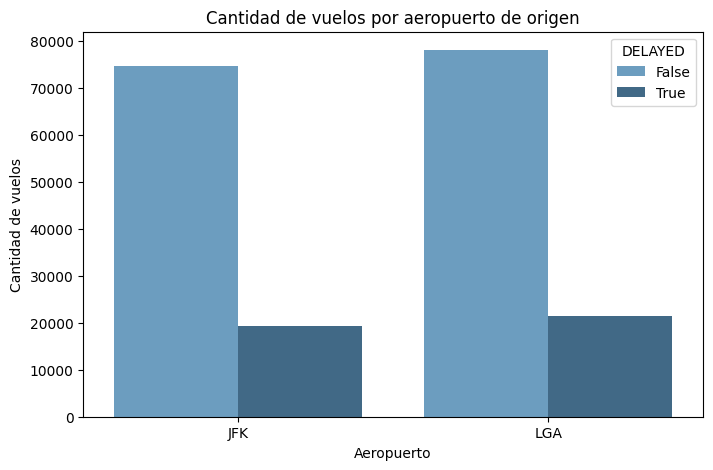

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=df_combined, x="ORIGIN_AIRPORT", hue="DELAYED", palette="Blues_d")
plt.title("Cantidad de vuelos por aeropuerto de origen")
plt.xlabel("Aeropuerto")
plt.ylabel("Cantidad de vuelos")
plt.show()

### Vuelos por aerolinea

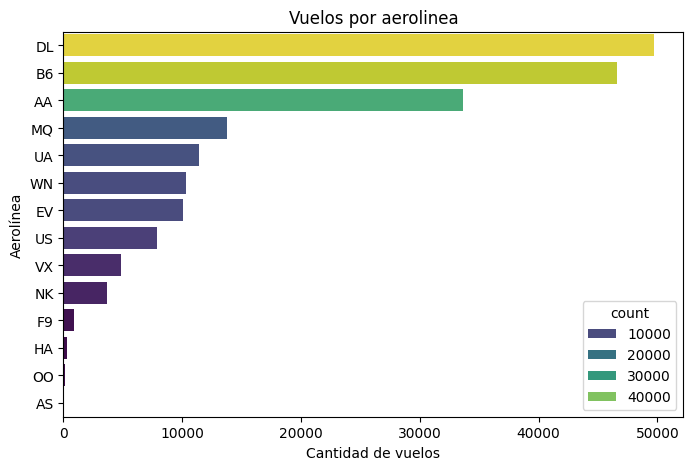

In [ ]:
plt.figure(figsize=(8,5))
top_airlines = df_combined["AIRLINE"].value_counts()
sns.barplot(x=top_airlines.values, y=top_airlines.index, hue=df_combined["AIRLINE"].value_counts(), palette="viridis")
plt.title("Vuelos por aerolinea")
plt.xlabel("Cantidad de vuelos")
plt.ylabel("Aerolínea")
plt.show()

### Porcentaje de vuelos con demora

In [ ]:
delay_rate = df_combined["DELAYED"].value_counts(normalize=True) * 100
delay_rate

,proportion
DELAYED,
False,78.924616
True,21.075384



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



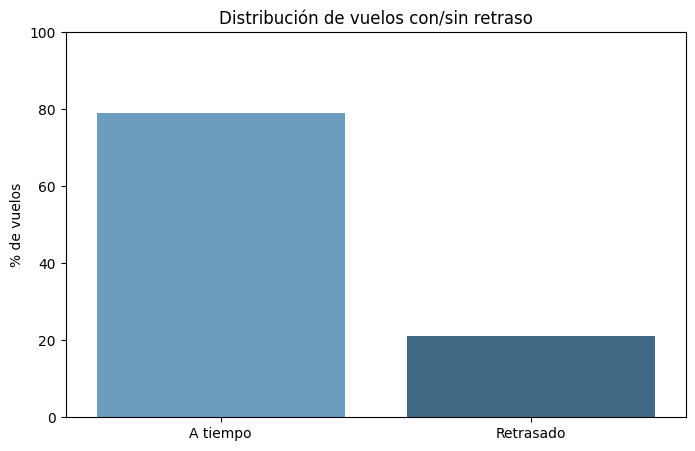

In [ ]:
plt.figure(figsize=(8,5))
delay_rate = df_combined["DELAYED"].value_counts(normalize=True) * 100
sns.barplot(x=delay_rate.index.map({False: "A tiempo", True: "Retrasado"}), y=delay_rate.values, palette="Blues_d")
plt.title("Distribución de vuelos con/sin retraso")
plt.ylabel("% de vuelos")
plt.xlabel("")
plt.ylim(0, 100)
plt.show()

In [ ]:
#calcular el porcentaje de vuelos con Delay por aerolinea
retraso_por_aerolinea = df_combined.groupby("AIRLINE")["DELAYED"].value_counts(normalize=True) * 100

retraso_por_aerolinea


AIRLINE  DELAYED
AA       False      83.676318
         True       16.323682
AS       False      90.666667
         True        9.333333
B6       False      77.955292
         True       22.044708
DL       False      77.793872
         True       22.206128
EV       False      76.119255
         True       23.880745
F9       False      65.789474
         True       34.210526
HA       False      93.515358
         True        6.484642
MQ       False      75.000000
         True       25.000000
NK       False      73.249796
         True       26.750204
OO       False      87.254902
         True       12.745098
UA       False      80.976504
         True       19.023496
US       False      83.237804
         True       16.762196
VX       False      85.045193
         True       14.954807
WN       False      75.347893
         True       24.652107
Name: proportion, dtype: float64

In [ ]:
# 1. Convertir los índices en columnas
retraso_por_aerolinea = retraso_por_aerolinea.reset_index()

# 2. Ahora sí, filtrar por la columna 'DELAYED'
retraso_por_aerolinea = retraso_por_aerolinea[retraso_por_aerolinea['DELAYED'] == True]

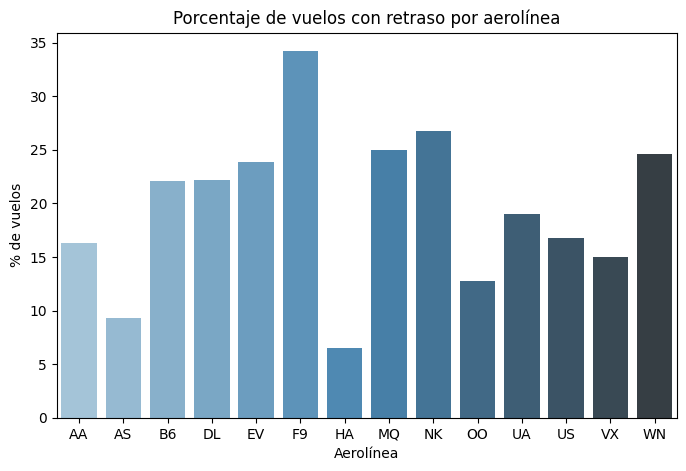

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(data= retraso_por_aerolinea, x="AIRLINE", y="proportion", hue="AIRLINE", palette="Blues_d")
plt.title("Porcentaje de vuelos con retraso por aerolínea")
plt.xlabel("Aerolínea")
plt.ylabel("% de vuelos")
plt.show()

In [ ]:
 # Frecuencia de direccionalidad del vieno
 df_viento = df_combined.groupby("wind_direction")["wind_category"].value_counts()
 df_viento

wind_direction  wind_category    
E               Brisa moderada        3111
                Brisa suave           2943
                Brisa fresca          1837
                Brisa ligera          1042
                Brisa fuerte           546
                Viento fuerte          112
N               Calma                12884
                Brisa moderada        8267
                Brisa suave           7398
                Brisa fresca          5738
                Brisa ligera          1916
                Brisa fuerte          1641
                Viento fuerte           80
                Viento muy fuerte       15
NE              Brisa moderada       10679
                Brisa suave           7091
                Brisa fresca          6161
                Brisa fuerte          1350
                Brisa ligera          1205
                Viento fuerte           45
NW              Brisa fresca         10208
                Brisa moderada        8833
                Brisa fuerte          6135
                Brisa suave           4881
                Viento fuerte         1886
                Brisa ligera          1362
                Viento muy fuerte      199
S               Brisa moderada       11881
                Brisa suave           7667
                Brisa fresca          7211
                Brisa fuerte          2393
                Brisa ligera          1346
                Viento fuerte          362
SE              Brisa moderada        2858
                Brisa fresca          2086
                Brisa suave           2013
                Brisa ligera           487
                Brisa fuerte           441
                Viento fuerte           62
SW              Brisa moderada       10670
                Brisa suave           8260
                Brisa fresca          4003
                Brisa ligera          1243
                Brisa fuerte           862
                Viento fuerte           54
W               Brisa fresca          7779
                Brisa moderada        6346
                Brisa fuerte          3713
                Brisa suave           3165
                Brisa ligera           606
                Viento fuerte          309
Name: count, dtype: int64

In [ ]:
df_viento = df_viento.reset_index()

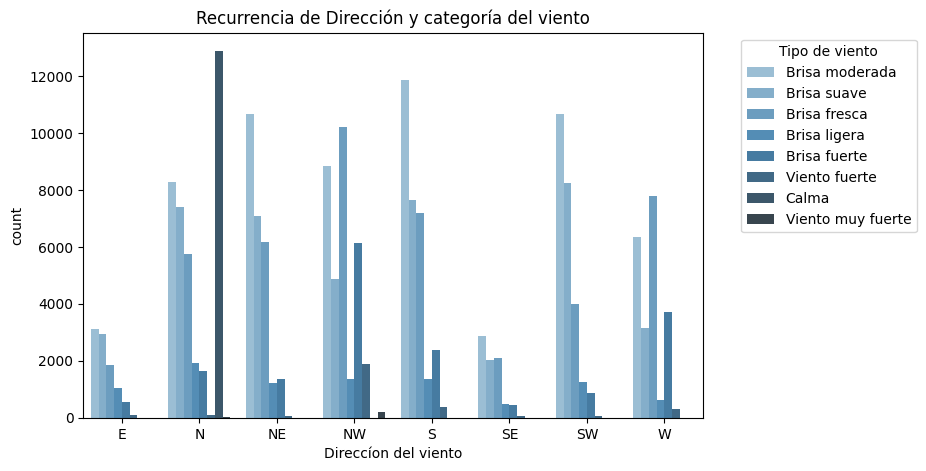

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(data= df_viento, x="wind_direction"	, y="count", hue="wind_category", palette="Blues_d")
plt.title("Recurrencia de Dirección y categoría del viento")
plt.xlabel("Direccíon del viento")
plt.ylabel("count")
plt.legend(title='Tipo de viento', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

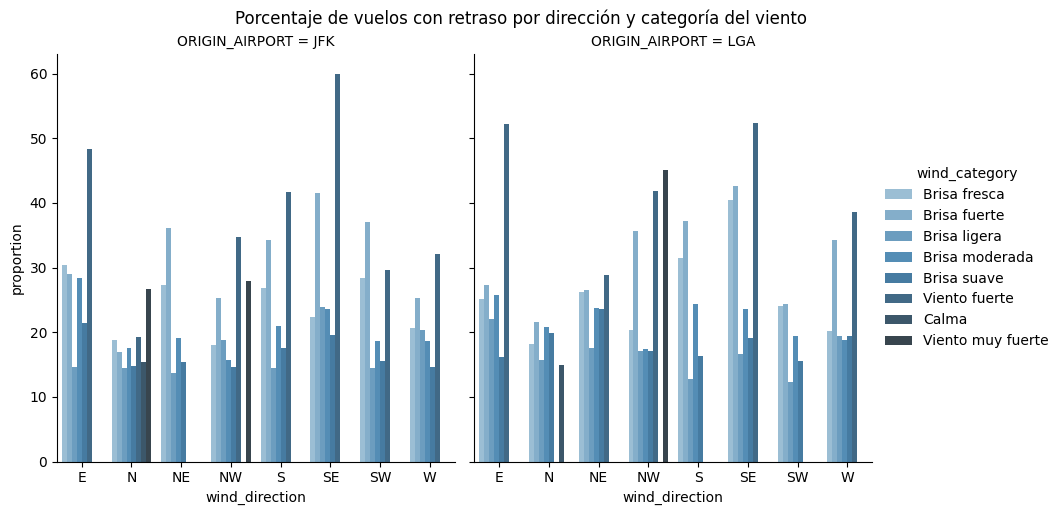

In [ ]:
df_retrasos_viento = df_combined.groupby(["wind_direction","wind_category","ORIGIN_AIRPORT"])["DELAYED"].value_counts(normalize=True)*100
df_retrasos_viento = df_retrasos_viento.reset_index()
df_retrasos_viento = df_retrasos_viento[df_retrasos_viento["DELAYED"] == True]

sns.catplot(data= df_retrasos_viento, x="wind_direction", y="proportion", col="ORIGIN_AIRPORT", kind="bar", hue="wind_category", height=5, aspect=0.9, palette="Blues_d")
plt.suptitle("Porcentaje de vuelos con retraso por dirección y categoría del viento", y=1.02)
plt.show()

<Axes: xlabel='temp', ylabel='Count'>

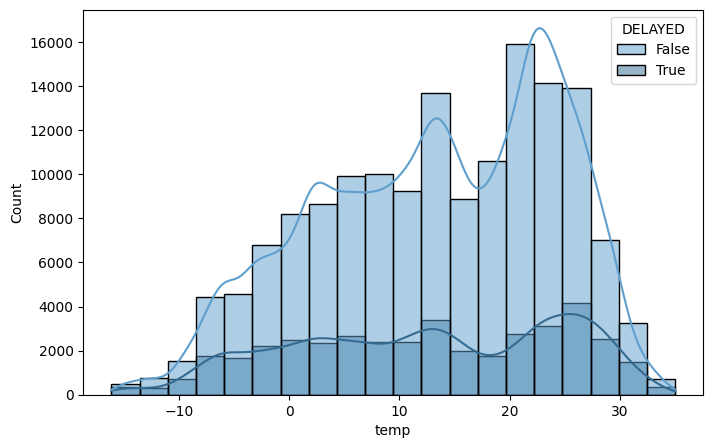

In [ ]:
# histograma de temperatura
plt.figure(figsize=(8,5))
sns.histplot(data=df_combined, x="temp", bins= 20, hue="DELAYED", palette="Blues_d", kde=True)

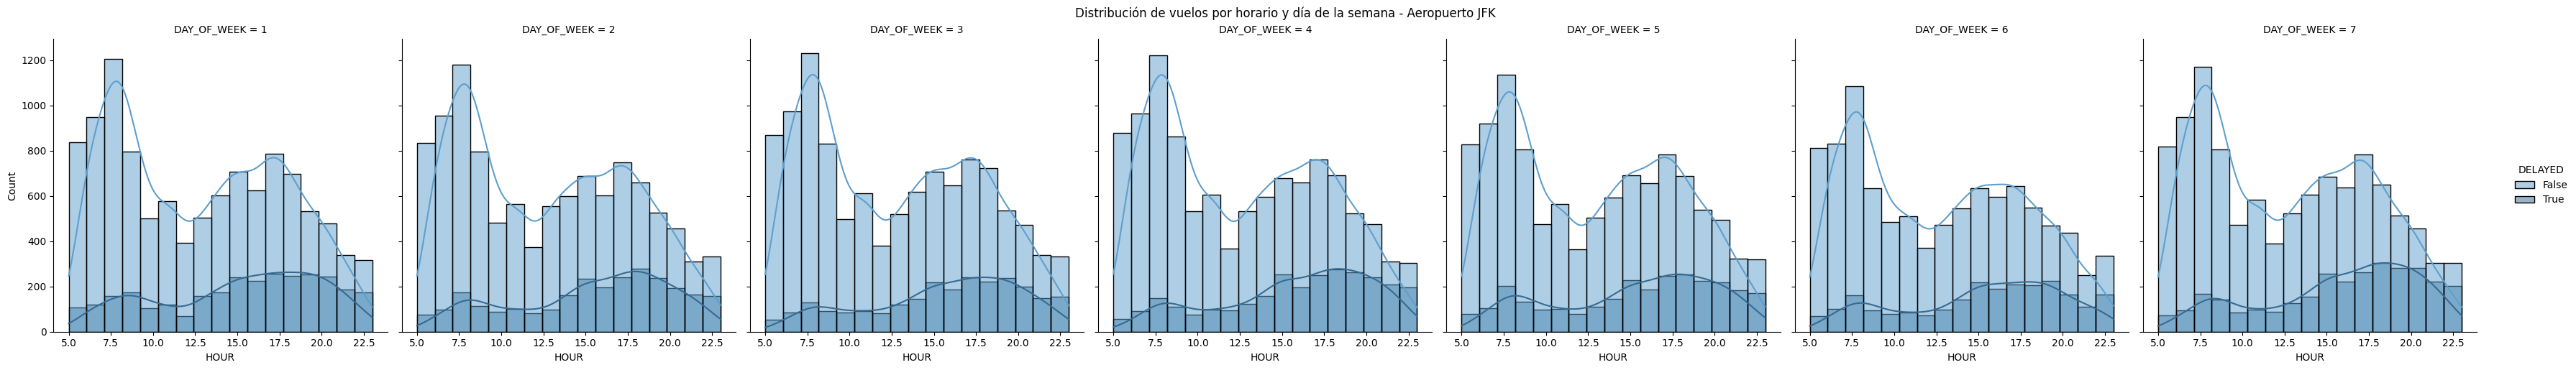

In [ ]:
# histograma por vuelos por horario y día de la semana

df_jfk = df_combined[df_combined["ORIGIN_AIRPORT"] == "JFK"]
df_lga = df_combined[df_combined["ORIGIN_AIRPORT"] == "LGA"]

sns.displot(data=df_jfk, x="HOUR", col= "DAY_OF_WEEK", hue="DELAYED", bins= 17, palette="Blues_d", kde=True)
plt.suptitle("Distribución de vuelos por horario y día de la semana - Aeropuerto JFK", y=1.02)
plt.ylabel ("vuelos")
plt.show()

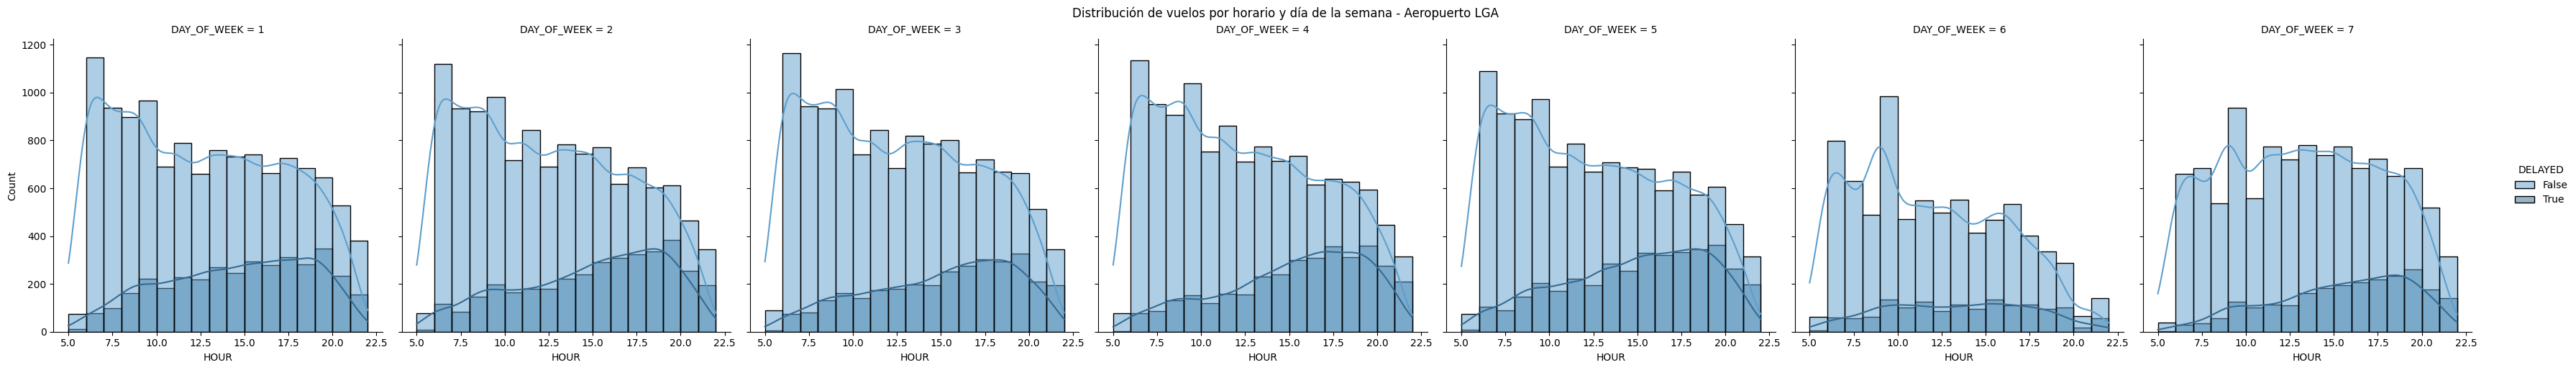

In [ ]:
sns.displot(data=df_lga, x="HOUR", col= "DAY_OF_WEEK", hue="DELAYED", bins= 17, palette="Blues_d", kde=True)
plt.suptitle("Distribución de vuelos por horario y día de la semana - Aeropuerto LGA", y=1.02)
plt.ylabel ("vuelos")
plt.show()